# Network Project

*By Daniel Deutsch, Joseé Lucas Barretto, Karim Jaber and Ziyad Bekkaoui*

In [4]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pytrends import dailydata
import networkx as nx

In [5]:
# Filter warnings
warnings.filterwarnings('ignore')

# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Data Import

In [11]:
# Import the wikileaks dataset
df = pd.read_parquet('datasets/wikileaks.parquet')

# Import Google Trends Data
#df_trends = dailydata.get_daily_data('wikileaks', start_year=2011, start_mon=1, stop_year=2022, stop_mon=1, geo='US', verbose=False, wait_time=0.1)

# Data Processing

In [17]:
# Process the Wikileaks dataframe
df['date'] = pd.to_datetime(df['time'], unit='s')
#df_trends.rename(columns={'PriceUSD': 'price_usd', 'valueUSD': 'value_usd'}, inplace=True)
df.sort_values(by='date', inplace=True)

# Process the Google Trends dataframe
# df_trends = df_trends[['wikileaks_unscaled']]
# df_trends = df_trends.reset_index()
# df_trends.rename(columns={'wikileaks_unscaled': 'trend'}, inplace=True)

# Donations to Wikileaks Over Time

In [15]:
wikileaks_dsts = ['1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v', '1MaXZE92yjuy4NYjTspmdWHMRT3jQUcTf4']

In [16]:
wikileaks_dst = (df['dst'] == '1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v') |  (df['dst'] == '1MaXZE92yjuy4NYjTspmdWHMRT3jQUcTf4')
df_value_donations = df.loc[wikileaks_dst].groupby(df.loc[wikileaks_dst].loc[:, 'time'].dt.date).sum()[['valueUSD']]
df_count_donations = df.loc[wikileaks_dst].groupby(df.loc[wikileaks_dst].loc[:, 'time'].dt.date).count()[['valueUSD']]

AttributeError: Can only use .dt accessor with datetimelike values

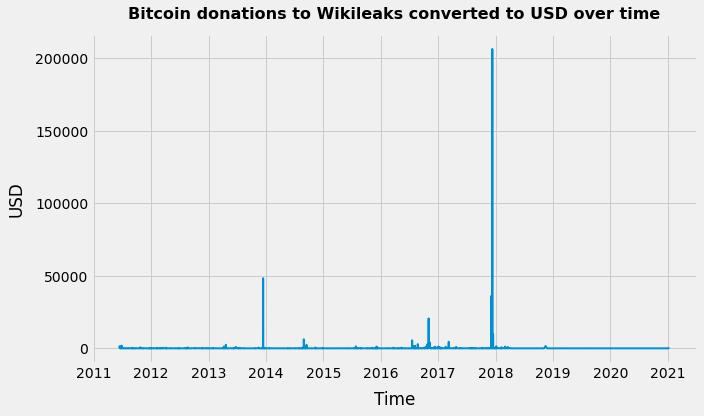

In [ ]:
plt.figure()
plt.plot(df_value_donations.index, df_value_donations.valueUSD)
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Bitcoin donations to Wikileaks converted to USD over time')
plt.show()

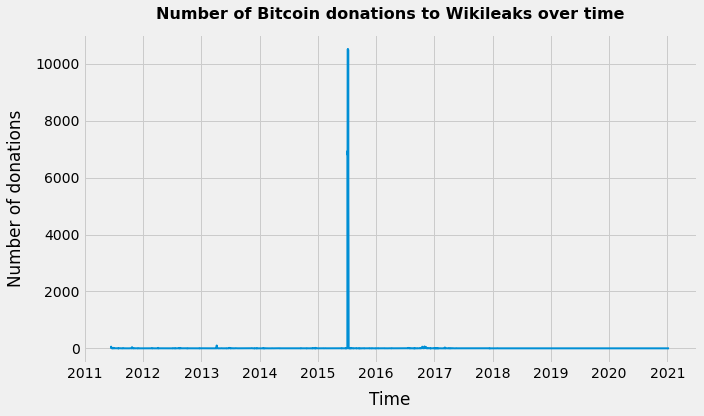

In [ ]:
plt.figure()
plt.plot(df_count_donations.index, df_count_donations.valueUSD)
plt.ylabel('Number of donations')
plt.xlabel('Time')
plt.title('Number of Bitcoin donations to Wikileaks over time')
plt.show()

In [ ]:
df_trends = dailydata.get_daily_data('wikileaks', 2011, 1, 2022, 1, wait_time=0.01, verbose=False)['wikileaks_unscaled']
df_trends = pd.merge(df_trends, df_count_donations, how='inner', right_index=True, left_index=True)

The request failed: Google returned a response with code 429.
Trying again in 60 seconds.


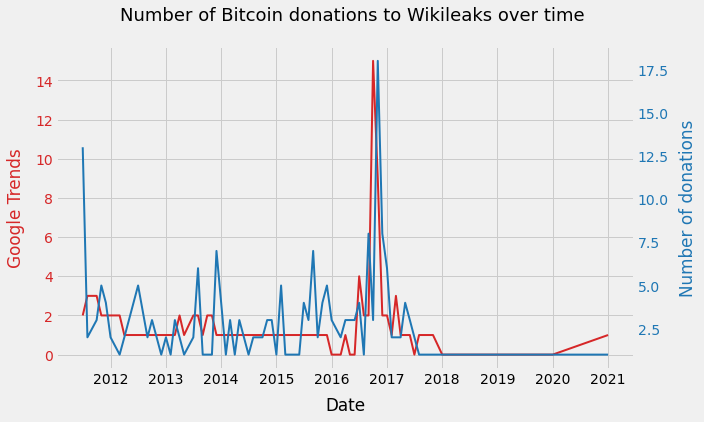

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Google Trends', color=color)
ax1.plot(df_trends.index, df_trends.wikileaks, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of donations', color=color)  # we already handled the x-label with ax1
ax2.plot(df_trends.index, df_trends.valueUSD, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

fig.suptitle('Number of Bitcoin donations to Wikileaks over time')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
df_trends.corr()

,wikileaks,valueUSD
wikileaks,1.000000,0.368832
valueUSD,0.368832,1.000000


In [ ]:
plt.figure()
plt.plot(df_count_donations.index, df_count_donations.valueUSD)
plt.ylabel('Number of donations')
plt.yscale('log')
plt.xlabel('Time')
plt.title('Number of Bitcoin donations to Wikileaks over time')
plt.show()

## Network Analysis

In [ ]:
wikileaks_dst = ['1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v', '1MaXZE92yjuy4NYjTspmdWHMRT3jQUcTf4']

In [226]:
# group source-destination pairs
df_network = df.groupby(['src', 'dst']).sum()['valueUSD'].reset_index()
df_network = df_network[df_network['dst'].isin(wikileaks_dsts)]
df_network.replace(
    {
        '1HB5XMLmzFVj8ALj6mfBsbifRoD4miY36v': 'wikileaks', 
        '1MaXZE92yjuy4NYjTspmdWHMRT3jQUcTf4': 'wikileaks'
    }, 
    inplace=True)

# select top 100 interactions in terms of value
df_network = df_network.sort_values(by='valueUSD', ascending=False).iloc[:200]

# create graph of donation network
G = nx.from_pandas_edgelist(df_network, source='src', target='dst', edge_attr=True, create_using=nx.DiGraph())

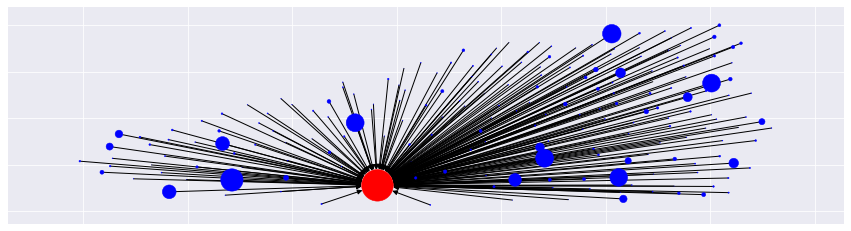

In [229]:
# plot donation network
size_dict = dict(zip(df_network['src'], (df_network['valueUSD'] - df_network['valueUSD'].min())/(df_network['valueUSD'].max() - df_network['valueUSD'].min())))

colors = []
sizes = []
for node in G:
    if node == 'wikileaks':
        colors.append("red")
        sizes.append(1000)
    else: 
        colors.append("blue")
        sizes.append(500*size_dict[node])

nx.draw_networkx(
    G, 
    arrows=True, 
    with_labels=False, 
    node_size=sizes, 
    node_color=colors,
    label='Graphical representation of WikiLeaks donations.' 
    )